<a href="https://colab.research.google.com/github/MrCharli03/RL_BFRRCE/blob/main/Estudio_Taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Esteban Becerra, Carlos Cruzado, Anastasiya Ruzhytska  
Email: esteban.becerraf@um.es carlos.cruzadoe1@um.es anastasiya.r.r@um.es  
Date: 2025/02/23

# Planteamiento del Problema

El objetivo principal de este estudio es desarrollar y evaluar agentes de aprendizaje por refuerzo en el entorno **Taxi-v3** de Gymnasium. En este entorno, el agente (representado por un taxi) debe aprender a:

- Navegar por una cuadrícula discretizada.
- Recoger a un pasajero en una ubicación designada.
- Transportar y dejar al pasajero en el destino correcto.

Para lograrlo, se implementan y comparan diferentes estrategias y algoritmos, entre los que se encuentran:
- **Monte Carlo On-Policy y Off-Policy:** Métodos que actualizan la función de valor a partir de episodios completos, utilizando distintas estrategias de muestreo.
- **SARSA:** Un método basado en la actualización de la función Q que considera la acción seleccionada en el siguiente estado.
- **Q-Learning:** Un enfoque off-policy que actualiza los valores Q utilizando el máximo valor estimado para el siguiente estado.

La meta es que, a través de la interacción con el entorno, el agente aprenda una política óptima que maximice la recompensa acumulada en cada episodio.

Además, en este entorno la función de recompensa está diseñada para guiar al agente hacia un comportamiento eficiente y seguro. Las recompensas se asignan de la siguiente manera:

- **Recompensa Positiva:**  
  - Se otorga un **bonus (por ejemplo, +20)** cuando el taxi deposita al pasajero en el destino correcto. Este incentivo refuerza la meta principal del agente.

- **Coste por Movimiento:**  
  - Cada acción (por ejemplo, moverse de una casilla a otra) genera un **coste (por ejemplo, -1)**. Este coste penaliza la ineficiencia y motiva al agente a encontrar la ruta más corta.

- **Penalizaciones por Acciones Incorrectas:**  
  - Se aplican **penalizaciones (por ejemplo, -10)** cuando se realizan acciones no permitidas o erróneas, como:
    - Intentar recoger a un pasajero cuando ya se está transportando uno.
    - Intentar dejar un pasajero en un destino no autorizado.

Estas reglas de recompensa y penalización permiten que el agente aprenda a través de la experiencia a maximizar la recompensa total en cada episodio, equilibrando el coste de cada movimiento con el beneficio de completar la tarea de forma correcta y eficiente.



In [1]:
#@title Instalacion de librerias necesarias
!pip install gymnasium

# Instalación de algunos paquetes.
!apt-get update

# Para visualizar en colab https://medium.com/@coldstart_coder/visually-rendering-python-gymnasium-in-jupyter-notebooks-4413e4087a0f
!apt-get install -y python-opengl ffmpeg
!apt-get install --upgrade cmake

# Para usar gymnasium[box2d]
!apt install swig xvfb
!pip install -U  pyvirtualdisplay


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,369 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,731 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/

In [2]:
#@title Importación de librerias

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import re
import io
import base64
from IPython import display
from IPython.display import HTML
from pyvirtualdisplay import Display
from tqdm import tqdm

SEMILLA

In [3]:
import os
import gc
import torch
import numpy as np
import gymnasium as gym

# Configuración del dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Liberación de memoria para evitar problemas de consumo en GPU
gc.collect() # Ejecuta el recolector de basura de Python
torch.cuda.empty_cache() # Vacía la caché de memoria en GPU

# Depuración de errores en CUDA
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # Muestra errores de CUDA en el punto exacto donde ocurren

# Configuración de la semilla para reproducibilidad
seed = 2024 # Se define una semilla fija

# Fijar la semilla en NumPy
np.random.seed(seed) # Para generar números aleatorios consistentes en NumPy
np.random.default_rng(seed) # Establece una instancia del generador de NumPy con la misma semilla

# Fijar la semilla en Python
os.environ['PYTHONHASHSEED'] = str(seed) # Evita variabilidad en hashing de Python

# Fijar la semilla en PyTorch
torch.manual_seed(seed) # Asegura resultados reproducibles en operaciones de PyTorch

if torch.cuda.is_available(): # Si hay GPU disponible
    torch.cuda.manual_seed(seed) # Fija la semilla para la GPU
    torch.backends.cudnn.deterministic = True # Hace las operaciones de CUDNN determinísticas
    torch.backends.cudnn.benchmark = False # Desactiva optimizaciones de CUDNN para evitar variabilidad

Usando dispositivo: cuda


# Declaracion de entornos

In [4]:
#@title Importamos el Taxi
name = 'Taxi-v3'

# Creamos el entorno Taxi-v3
env = gym.make(name, render_mode="rgb_array")

#Funciones para representar las graficas

La funcion *plot_episode_lengths:* se encarga de representar la evolución de la longitud de los episodios. Para ello, toma como entrada una lista o array de longitudes de episodios y, mediante una regresión lineal, calcula una línea de tendencia que se superpone a los datos originales. El gráfico resultante muestra en el eje X el número de episodio y en el eje Y la longitud del mismo, permitiendo visualizar tanto la variabilidad de cada episodio como la tendencia general a lo largo del entrenamiento.

In [5]:
#@title Funcion para mostrar los episodios
def plot_episode_lengths(episode_lengths, window_size=10):
    # Convertir a array por si acaso
    episode_lengths = np.array(episode_lengths)

    # Ajustar una regresión lineal a los datos
    x = np.arange(len(episode_lengths))
    coefficients = np.polyfit(x, episode_lengths, 1)  # Regresión lineal (grado 1)
    trend_line = np.polyval(coefficients, x)  # Calcular la línea de tendencia

    plt.figure(figsize=(8, 4))
    plt.plot(episode_lengths, label="Longitud del episodio", alpha=0.5)
    # Graficar la línea de tendencia en lugar de la media móvil
    plt.plot(x, trend_line, label="Línea de tendencia", color='red')
    plt.xlabel("Episodio")
    plt.ylabel("Longitud")
    plt.title("Evolución de la longitud de los episodios")
    plt.grid(True)
    plt.legend()
    plt.show()

La función *plot* se utiliza para visualizar la evolución de la proporción de recompensas obtenidas a lo largo de los episodios. De manera similar a la anterior, esta función convierte la lista de estadísticas en un array y aplica una regresión lineal para obtener una línea de tendencia, que se dibuja junto a los datos crudos. El gráfico final, con ejes etiquetados y una leyenda descriptiva, ayuda a observar de forma clara cómo varía la proporción de recompensas a medida que se entrenan los agentes.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot(list_stats, window_size=10):
    indices = list(range(len(list_stats)))

    # Convertir a array para asegurar el correcto manejo
    list_stats = np.array(list_stats)

    # Ajustar una regresión lineal a los datos
    x = np.arange(len(list_stats))
    coefficients = np.polyfit(x, list_stats, 1)  # Regresión lineal (grado 1)
    trend_line = np.polyval(coefficients, x)  # Calcular la línea de tendencia

    plt.figure(figsize=(8, 4))
    plt.plot(indices, list_stats, label='Proporción de recompensas', alpha=0.5)
    plt.plot(x, trend_line, label="Línea de tendencia", color='red')  # Graficar la línea de tendencia
    plt.title('Proporción de recompensas')
    plt.xlabel('Episodio')
    plt.ylabel('Proporción')
    plt.grid(True)
    plt.legend()
    plt.show()

La función *plot_comparison* está diseñada para comparar dos conjuntos de métricas, generalmente las proporciones de recompensas obtenidas por agentes que siguen estrategias On-Policy y Off-Policy. Esta función toma dos listas de datos, las convierte en arrays y traza ambos conjuntos en un mismo gráfico, lo que facilita la comparación visual entre ambas estrategias. Aunque incluye comentarios sobre la posibilidad de graficar medias móviles, su implementación actual muestra directamente los datos crudos con una configuración de título, etiquetas y leyenda que clarifica la comparación entre los dos métodos.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_comparison(list_stats_on, list_stats_off, recompensas, window_size=10):
    # Convertir a arrays para garantizar el correcto manejo de datos
    list_stats_on = np.array(list_stats_on)
    list_stats_off = np.array(list_stats_off)

    indices_on = np.arange(len(list_stats_on))
    indices_off = np.arange(len(list_stats_off))

    plt.figure(figsize=(10, 5))

    # Graficar datos originales
    plt.plot(indices_on, list_stats_on, label="On-Policy (raw)", alpha=0.5)
    plt.plot(indices_off, list_stats_off, label="Off-Policy (raw)", alpha=0.5)

    # Configuración del gráfico
    plt.title("Comparación: On-Policy vs Off-Policy")
    plt.xlabel("Episodio")
    if recompensas is True:
      plt.ylabel("Proporción de recompensas")
    else:
      plt.ylabel("Longitud de los episodios")
    plt.legend()
    plt.grid(True)
    plt.show()

# Funciones para crear y reproducir los videos

La función *get_latest_episode_video_file* busca, dentro de un directorio especificado, el archivo de video que corresponde al episodio más reciente. Utiliza una expresión regular para identificar aquellos archivos que sigan el patrón "rl-video-episode-(número).mp4". Al recorrer los archivos del directorio, compara el número extraído de cada nombre y devuelve la ruta del archivo que tenga el mayor valor, asegurando así que se obtiene el video del episodio más actual.

In [10]:
def get_latest_episode_video_file(directory):
    """
    Devuelve el nombre (con ruta) del video .mp4 de episodio
    más reciente en 'directory', siguiendo el patrón
    'rl-video-episode-.mp4'.
    """
    pattern = re.compile(r"rl-video-episode-(\d+)\.mp4")
    latest_file = None
    highest_episode = -1
    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            episode_number = int(match.group(1))
            if episode_number > highest_episode:
                highest_episode = episode_number
                latest_file = os.path.join(directory, filename)
    return latest_file

La función *embed_video* se encarga de incrustar y reproducir un video directamente en el notebook. Para ello, abre el archivo de video en modo binario, lo codifica en formato base64 y luego utiliza un fragmento de HTML que contiene la etiqueta `<video>` para mostrarlo. Este método permite visualizar el video sin necesidad de utilizar reproductores externos, integrando la experiencia de reproducción de manera interactiva en el entorno del notebook.

In [11]:
def embed_video(video_file):
    """
    Incrusta el video .mp4 en el notebook a partir de su ruta.
    """
    video_data = io.open(video_file, 'r+b').read()
    encoded_data = base64.b64encode(video_data).decode()
    display.display(HTML(data=f'''
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{encoded_data}" type="video/mp4">
            Your browser does not support the video tag.
        </video>'''))


La función *record_policy_with_fn:* graba episodios completos ejecutando una política definida por el usuario. Inicialmente, crea la carpeta de destino para los videos (si aún no existe) y envuelve el entorno de Gym con el wrapper *RecordVideo*, el cual se encarga de capturar cada frame durante la ejecución del episodio. A continuación, por cada episodio, la función reinicia el entorno, ejecuta la política para seleccionar acciones y renderiza cada frame para que el proceso de grabación se lleve a cabo. Finalmente, retorna la ruta del directorio donde se almacenan los videos, facilitando el acceso y posterior reproducción de los episodios grabados.

In [12]:
def record_policy_with_fn(policy_fn, env=env, num_episodes=3, video_dir="videos"):
    """
    Graba episodios usando la función de política 'policy_fn' para seleccionar acciones.
    """
    import os, gym
    os.makedirs(video_dir, exist_ok=True)
    env = gym.wrappers.RecordVideo(env, video_folder=video_dir)

    for _ in range(num_episodes):
        state, _ = env.reset(seed=seed)
        done = False
        while not done:
            action = policy_fn(state)
            # Handle different Gymnasium versions
            step_result = env.step(action)
            if len(step_result) == 4:  # For older versions
                state, _, done, _ = step_result
            else:  # For Gymnasium 0.26+
                state, _, terminated, truncated, _ = step_result
                done = terminated or truncated
            env.render()  # Necesario para capturar cada frame
    env.close()
    return video_dir

# Aplico Politica Greedy

La función **optimal_policy_from_q** utiliza la tabla Q para derivar la política óptima. Comienza en el estado inicial y, en cada paso, selecciona la acción con mayor valor (estrategia greedy), registrando las acciones y capturando cada frame renderizado. De esta manera, permite evaluar visualmente el comportamiento del agente al seguir la política óptima derivada de la tabla Q.

In [13]:
def optimal_policy_from_q(env, q_table, seed=None):
    """
    Ejecuta el entorno utilizando una política GREEDY a partir de q_table.

    Devuelve:
    - optimal_policy: Matriz que representa la acción óptima elegida en cada estado.
    - action_log: Cadena con el registro de las acciones tomadas.
    - frames_list: Lista de frames capturados durante la ejecución.
    """
    import numpy as np

    frames_list = []
    done = False
    optimal_policy = np.zeros([env.observation_space.n, env.action_space.n])
    initial_state, info = env.reset(seed=seed)  # Arranca en el estado inicial
    frame = env.render()
    frames_list.append(frame)
    action_log = ""

    current_state = initial_state
    while not done:
        # Obtener los valores Q para el estado actual y seleccionar la mejor acción
        q_values = q_table[current_state]
        best_action = np.argmax(q_values)

        # Registrar la acción
        action_log += f"{best_action}, "
        optimal_policy[current_state, best_action] = best_action

        # Ejecutar la acción en el entorno
        current_state, reward, terminated, truncated, info = env.step(best_action)
        frame = env.render()
        frames_list.append(frame)
        done = terminated or truncated

    return optimal_policy, action_log, frames_list

# **Monte Carlo**

La funcion *evaluate_policy* se utiliza para evaluar la política derivada a partir de Monte Carlo. Inicia reiniciando el entorno y captura el primer frame renderizado; luego, en cada iteración, selecciona la acción óptima consultando el vector de política (optimal_policy_vector) para el estado actual. A medida que el agente ejecuta las acciones en el entorno, se registra cada acción y se acumulan los frames renderizados hasta alcanzar un estado terminal. Finalmente, la función devuelve el registro de acciones y la secuencia de frames, permitiendo analizar la efectividad de la política aplicada.

In [14]:
#@title Funcion para la evaluación de la politica de Monte Carlo
def evaluate_policy(env, optimal_policy_vector, seed=None):
    state, info = env.reset(seed=seed)
    done = False
    action_log = []
    frames = []

    # Guardamos el primer frame
    frames.append(env.render())

    while not done:
        # Seleccionamos la acción óptima para el estado actual
        action = optimal_policy_vector[state]
        action_log.append(action)

        # Ejecutamos la acción en el entorno
        state, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())

        done = terminated or truncated

    return action_log, frames

La funcion *optimal_policy_fn* actúa como un envoltorio simple para la política óptima calculada. Recibe un estado como entrada y devuelve directamente la acción correspondiente, según lo establecido en el vector de política óptima (optimal_policy_vector). Su simplicidad facilita la integración en otros procesos, como la grabación de episodios o la evaluación de la política, ya que encapsula la lógica de selección de acción en una única línea.

In [15]:
#@title Funcion para obtener la acción óptima para un estado dado
def optimal_policy_fn(state):
    return optimal_policy_vector[state]

## On policy

Este método evalúa y mejora la política que se utiliza para generar episodios. Durante la ejecución, se generan episodios completos utilizando la política actual, y se calcula el retorno acumulado para cada par estado-acción con el método every-visit (todas las visitas). A partir de estos retornos, se actualiza la función de valor Q a través de promedios, de manera que la política se refina iterativamente basándose en la experiencia directa obtenida con ella, garantizando la coherencia entre la evaluación y la generación de datos.

Definimos la clase del agente

In [16]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

env_mc_on = gym.make("Taxi-v3", render_mode="rgb_array")
env_mc_on = gym.wrappers.RecordVideo(env_mc_on, video_folder="videos_mc_on")

# Hiperparámetros
NUM_EPISODES = 20000
GAMMA = 0.99       # Factor de descuento
EPSILON = 1.0      # Probabilidad de exploración
EPSILON_DECAY = 0.9999
MIN_EPSILON = 0.01

# Clase MonteCarloOnPolicyAgent
class MonteCarloOnPolicy:
    def __init__(self, env, gamma, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Inicializamos Q y el contador de visitas para cada par (estado, acción)
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.N = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    # Política de comportamiento (ε-greedy)
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración: acción aleatoria
        else:
            return np.argmax(self.Q[state])  # Explotación: mejor acción según Q

    # Actualizar la tabla Q usando Monte Carlo On-Policy
    def update(self, episode):
        G = 0  # Retorno total

        # Recorrer el episodio en reversa
        for state, action, reward in reversed(episode):
            G = self.gamma * G + reward
            # Incrementar el contador para este par (state, action)
            self.N[state, action] += 1
            #self.Q[state, action] += (G - self.Q[state, action]) / (t + 1)  # Promedio incremental
            self.Q[state, action] += (G - self.Q[state, action]) / self.N[state, action]

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

Iniciamo el agente y entrenamos al agente

In [17]:
# Inicializar el agente
agent = MonteCarloOnPolicy(
    env=env_mc_on,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode_mc_on = []
episodes_sizes_mc_on = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env_mc_on.reset(seed=seed)
    done = False
    episode_reward = 0
    episode_steps = 0
    episode_data = []

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env_mc_on.step(action)

        # Guardar datos del episodio
        episode_data.append((obs, action, reward))

        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Actualizar el agente con el episodio completo
    agent.update(episode_data)

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode_mc_on.append(episode_reward)
    episodes_sizes_mc_on.append(episode_steps)

    # Para mostrar la evolución. Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

 10%|▉         | 1981/20000 [00:43<01:10, 255.83it/s]

Éxito promedio: -531.5175, Épsilon: 0.8186406930090225


 20%|█▉        | 3967/20000 [00:50<00:28, 565.01it/s]

Éxito promedio: -350.5335, Épsilon: 0.6702396082111141


 30%|██▉       | 5986/20000 [00:53<00:17, 820.54it/s]

Éxito promedio: -258.83483333333334, Épsilon: 0.548740291377179


 40%|███▉      | 7940/20000 [00:56<00:14, 856.50it/s]

Éxito promedio: -205.085375, Épsilon: 0.4492660590208893


 49%|████▉     | 9873/20000 [00:59<00:07, 1295.31it/s]

Éxito promedio: -169.2567, Épsilon: 0.3678242603283259


 60%|█████▉    | 11900/20000 [01:01<00:05, 1441.46it/s]

Éxito promedio: -143.62866666666667, Épsilon: 0.3011460219829101


 70%|███████   | 14099/20000 [01:03<00:05, 989.86it/s] 

Éxito promedio: -124.42942857142857, Épsilon: 0.24655504363736244


 80%|████████  | 16014/20000 [01:04<00:03, 1070.99it/s]

Éxito promedio: -109.5421875, Épsilon: 0.20186017780594118


 90%|█████████ | 18024/20000 [01:06<00:01, 1167.81it/s]

Éxito promedio: -97.53711111111112, Épsilon: 0.16526748259824006


100%|██████████| 20000/20000 [01:07<00:00, 297.46it/s] 


Observando la siguiente grafica vemos que mientras avanza el entrenamiento, la línea de tendencia (en rojo) muestra que las recompensas promedio van mejorando (se vuelven menos negativas), lo cual indica que el agente va aprendiendo a completar la tarea con menor coste y menos errores. Paralelamente, se aprecia la disminución progresiva de ε en el registro de entrenamiento, lo que implica que el agente pasa de una fase de exploración intensa a otra de mayor explotación de la política aprendida.

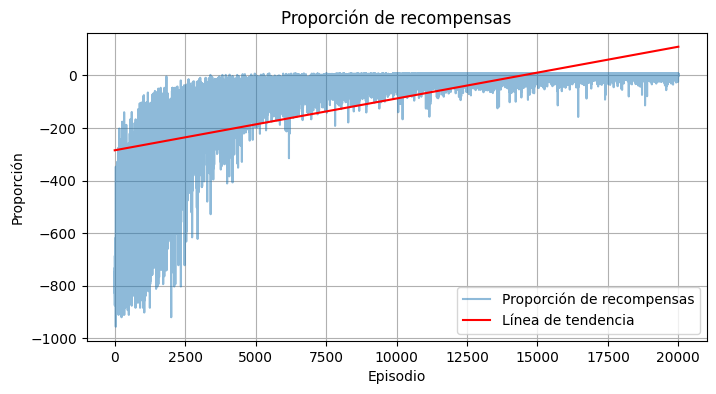

In [18]:
plot(rewards_per_episode_mc_on)  # Pass only rewards_per_episode

En cambio en la grafica que nos muestra la longitud de los episodios, vemos que al inicio  el agente tarda muchos pasos en entregar al pasajero (alrededor de 200 pasos o más), pero conforme aprende la dinámica del entorno y la mejor ruta, los episodios se acortan considerablemente. La línea de tendencia descendente confirma que el agente cada vez necesita menos movimientos para completar la tarea, reflejando una política más eficiente. Además, las cifras de “Éxito promedio” del log van de aproximadamente -531 a -97, lo que confirma cuantitativamente la mejora en el desempeño del agente a lo largo de las 20.000 iteraciones.

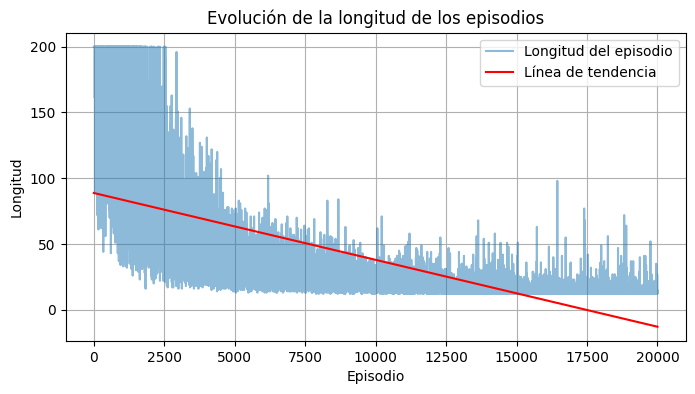

In [19]:
plot_episode_lengths(episodes_sizes_mc_on)

Extraemos la politica optima para despues poder mostrar un video con el camino solucion optimo encontrado por el agente.

In [20]:
# Extraer la política óptima para todos los estados
optimal_policy_vector = np.argmax(agent.Q, axis=1)
print("Política óptima (vector de acciones):\n", optimal_policy_vector)

# Evaluar la política en un episodio de prueba
action_log, frames_recorded = evaluate_policy(env_mc_on, optimal_policy_vector, seed=seed)
print("\nAcciones tomadas en la evaluación:\n", action_log)
print("\nGrid del entorno:\n", env_mc_on.render())


Política óptima (vector de acciones):
 [0 4 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 3 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 2 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 5 0 0 0 0 0 0 0 3 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0
 0 3 0 0 0 3 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 4 0 0 0
 0 0 0 0 0 0 0 0 3 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 4 0 0 0 2 0 0 0 2 0 0 0 4 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 1 0
 0 0 3 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 1 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 1 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 5 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 4
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 4 0 0 0 1 0 0 0 3 0 0 0 4 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 2 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 3 0 0 0 0 0 0 0 3 0 0 0 4 

Mostramos el video

In [21]:
video_dir = record_policy_with_fn(optimal_policy_fn, env=env_mc_on, video_dir="videos_mc_on")
latest_video_file = get_latest_episode_video_file(video_dir)
print("Video grabado:", latest_video_file)
embed_video(latest_video_file)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos_mc_on folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video grabado: videos_mc_on/rl-video-episode-20000.mp4


## OFF policy

En contraste, el método Off-Policy permite evaluar y mejorar una política objetivo utilizando datos generados por una política de comportamiento distinta. La diferencia entre ambas políticas se corrige aplicando técnicas de muestreo por importancia, que ponderan los retornos de cada par estado-acción según la probabilidad relativa de tomar la acción bajo la política objetivo versus la política de comportamiento. Esto posibilita la evaluación y mejora de la política objetivo sin necesidad de que ésta sea la que gobierne la generación de episodios, facilitando el aprendizaje y la optimización en escenarios donde explorar la política objetivo directamente resulta impráctico o ineficiente.

Definimos la clase del agente

In [22]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

env_mc_off = gym.make("Taxi-v3", render_mode="rgb_array")
env_mc_off = gym.wrappers.RecordVideo(env_mc_off, video_folder="videos_mc_off")

# Hiperparámetros
NUM_EPISODES = 20000
GAMMA = 0.99       # Factor de descuento
EPSILON = 1.0      # Probabilidad de exploración
EPSILON_DECAY = 0.999
MIN_EPSILON = 0.002

# Clase MonteCarloOffPolicyAgent
class MonteCarloOffPolicyAgent:
    def __init__(self, env, gamma, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Inicializamos Q y la suma de pesos acumulados C para cada par (estado, acción)
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.C = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    # Política de comportamiento (ε-greedy)
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración: acción aleatoria
        else:
            return np.argmax(self.Q[state])  # Explotación: acción greedy según Q

    # Actualizar la tabla Q usando Monte Carlo Off-Policy con muestreo por importancia ponderado
    def update(self, episode):
        G = 0  # Retorno acumulado
        W = 1  # Peso acumulado de importance sampling
        n_actions = self.env.action_space.n  # Número de acciones

        # Recorrer el episodio en reversa
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = self.gamma * G + reward

            # Acumular el peso para el par (state, action)
            self.C[state, action] += W
            # Actualización incremental de Q(s,a) con la suma acumulada de pesos
            self.Q[state, action] += (W / self.C[state, action]) * (G - self.Q[state, action])

            # Si la acción tomada no es la acción greedy según la política target, terminamos la actualización
            if action != np.argmax(self.Q[state]):
                break

            # Calcular la probabilidad de tomar la acción greedy bajo la política comportamiento
            b_prob = (1 - self.epsilon) + (self.epsilon / n_actions)
            # Actualizar el peso W usando la relación de importancia
            W = W * (1.0 / b_prob)

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)


Inicializamos el agente y lo entrenamos

In [23]:
# Inicializar el agente
agent = MonteCarloOffPolicyAgent(
    env=env_mc_off,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode_mc_off = []
episodes_sizes_mc_off = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env_mc_off.reset(seed=seed)
    done = False
    episode_reward = 0
    episode_steps = 0
    episode_data = []

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env_mc_off.step(action)

        # Guardar datos del episodio
        episode_data.append((obs, action, reward))

        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Actualizar el agente con el episodio completo
    agent.update(episode_data)

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode_mc_off.append(episode_reward)
    episodes_sizes_mc_off.append(episode_steps)

    # Para mostrar la evolución. Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

# Cerrar el entorno
env_mc_off.close()

 10%|▉         | 1986/20000 [00:35<00:15, 1166.94it/s]

Éxito promedio: -270.0825, Épsilon: 0.13506472547210188


 21%|██        | 4160/20000 [00:37<00:14, 1107.98it/s]

Éxito promedio: -133.2045, Épsilon: 0.018260740807661956


 30%|███       | 6010/20000 [00:38<00:11, 1245.98it/s]

Éxito promedio: -86.62333333333333, Épsilon: 0.0024688507948989738


 40%|███▉      | 7983/20000 [00:39<00:06, 1939.57it/s]

Éxito promedio: -63.24725, Épsilon: 0.002


 50%|█████     | 10023/20000 [00:41<00:08, 1151.64it/s]

Éxito promedio: -49.227, Épsilon: 0.002


 60%|██████    | 12023/20000 [00:42<00:06, 1279.57it/s]

Éxito promedio: -39.86991666666667, Épsilon: 0.002


 70%|██████▉   | 13951/20000 [00:43<00:03, 1919.51it/s]

Éxito promedio: -33.18835714285714, Épsilon: 0.002


 81%|████████  | 16108/20000 [00:45<00:03, 1266.10it/s]

Éxito promedio: -28.174875, Épsilon: 0.002


 90%|█████████ | 18075/20000 [00:46<00:01, 1131.80it/s]

Éxito promedio: -24.28, Épsilon: 0.002


100%|██████████| 20000/20000 [00:48<00:00, 412.55it/s] 


En la gráfica de *Proporción de recompensas*, se aprecia que la curva comienza con valores muy negativos (aproximadamente -1000 en los primeros episodios) y va mejorando rápidamente hasta estabilizarse cerca de 0. Este ascenso refleja cómo el agente reduce sus penalizaciones y obtiene recompensas menos negativas a medida que aprende la dinámica del entorno. Los valores del log confirman la tendencia: el éxito promedio pasa de alrededor de -270 en los primeros miles de episodios a cerca de -24 al final del entrenamiento.

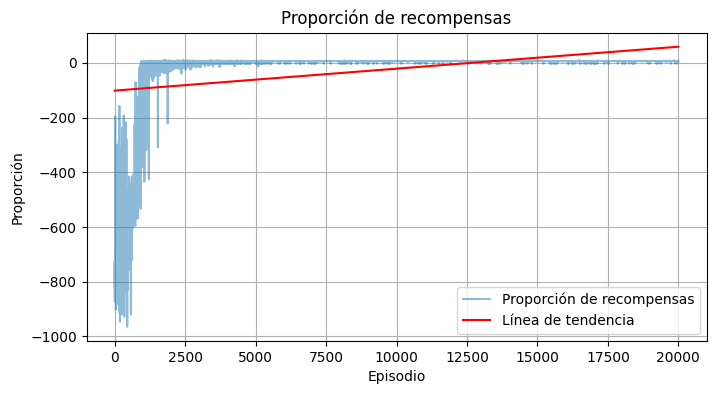

In [24]:
plot(rewards_per_episode_mc_off)  # Pass only rewards_per_episode

En la gráfica de *Evolución de la longitud de los episodios*, se observa un descenso drástico en el número de pasos que el agente necesita para completar la tarea. Al principio, algunos episodios superan con creces los 200 pasos, pero conforme avanza el entrenamiento, la longitud se reduce de manera notable, situándose en torno a 20-30 pasos. Esta marcada disminución sugiere que el agente encuentra rutas cada vez más eficientes para recoger y dejar al pasajero, optimizando su comportamiento a lo largo de los 20.000 episodios de entrenamiento.

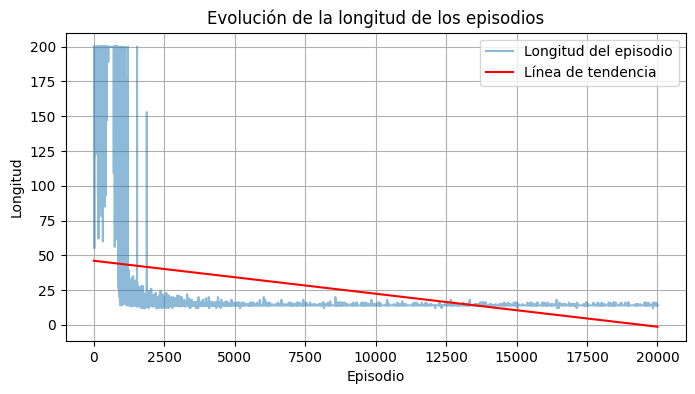

In [25]:
plot_episode_lengths(episodes_sizes_mc_off)

Extraemos la politica optima para despues poder mostrar un video con el camino solucion optimo encontrado por el agente.

In [26]:
# Extraer la política óptima para todos los estados
optimal_policy_vector = np.argmax(agent.Q, axis=1)
print("Política óptima (vector de acciones):\n", optimal_policy_vector)

# Evaluar la política en un episodio de prueba
action_log, frames_recorded = evaluate_policy(env_mc_off, optimal_policy_vector, seed=seed)
print("\nAcciones tomadas en la evaluación:\n", action_log)
print("\nGrid del entorno:\n", env_mc_on.render())

Política óptima (vector de acciones):
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 

Mostramos el video

In [27]:
video_dir = record_policy_with_fn(optimal_policy_fn, env=env_mc_off, video_dir="videos_mc_off")
latest_video_file = get_latest_episode_video_file(video_dir)
print("Video grabado:", latest_video_file)
embed_video(latest_video_file)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos_mc_off folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video grabado: videos_mc_off/rl-video-episode-20000.mp4


Comparación

En la *Gráfica de recompensas*, se observa que tanto el agente On-Policy (azul) como el Off-Policy (naranja) comienzan con valores muy negativos y van mejorando progresivamente hasta estabilizarse cerca de 0 (o valores menos negativos). Sin embargo, el método Off-Policy muestra una curva de aprendizaje algo más rápida y estable en sus primeras etapas, mientras que el agente On-Policy tiende a presentar una evolución más gradual. Esta diferencia se explica, en parte, porque el agente Off-Policy puede actualizar su política objetivo usando muestras generadas por una política de comportamiento distinta, lo que le ofrece más flexibilidad y puede acelerar el proceso de aprendizaje.

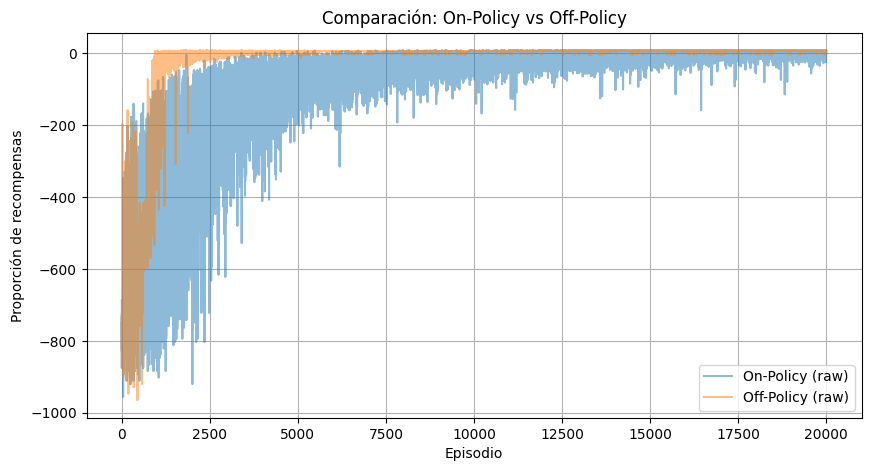

In [28]:
plot_comparison(rewards_per_episode_mc_on, rewards_per_episode_mc_off, True)

En la *Gráfica de la longitud de los episodios* (imagen inferior), se aprecia cómo el método Off-Policy (naranja) tiende a reducir la cantidad de pasos de manera más agresiva, manteniéndose generalmente por debajo del On-Policy (azul). Esto indica que el agente Off-Policy logra encontrar rutas y secuencias de acciones más eficientes con mayor rapidez, mientras que el agente On-Policy, pese a mejorar también de forma notable, presenta una variabilidad algo mayor y tarda un poco más en converger a episodios cortos. En conjunto, ambas gráficas muestran que, si bien On-Policy termina por alcanzar buenos resultados, Off-Policy ofrece un aprendizaje más acelerado y estable en este entorno de Taxi-v3.

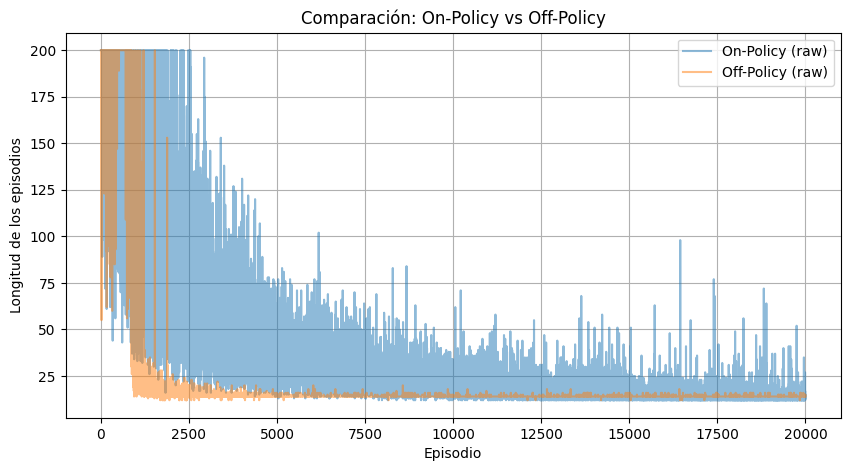

In [29]:
plot_comparison(episodes_sizes_mc_on, episodes_sizes_mc_off, False)

# **Diferencias Temporales**

Sarsa es un método de aprendizaje por diferencias temporales que opera de manera *on-policy*, lo que significa que evalúa y mejora la misma política que utiliza para seleccionar acciones. El nombre proviene de la secuencia \((S, A, R, S', A')\): estado actual, acción tomada, recompensa recibida, siguiente estado y la siguiente acción elegida por la política \(\varepsilon\)-greedy. La actualización de la función de acción-valor \(Q\) incorpora tanto la recompensa inmediata como el valor estimado de la siguiente acción que realmente se tomará, capturando así la naturaleza *on-policy* del método.  

A diferencia de métodos que buscan el máximo futuro, Sarsa se basa en la acción que efectivamente se elige en el siguiente paso. Esto hace que, en escenarios donde la exploración pueda ser riesgosa, Sarsa sea más conservador y se ajuste mejor a la política que está en uso, ya que incluye la probabilidad de acciones subóptimas en el cálculo de los retornos esperados. En consecuencia, Sarsa tiende a aprender un comportamiento que equilibra la exploración y la explotación de acuerdo con la política vigente en cada momento.

Q-Learning es otro método de aprendizaje por diferencias temporales, pero a diferencia de Sarsa, es *off-policy*. Su objetivo es aprender la política óptima, independientemente de las acciones que se tomen durante la recolección de datos. En lugar de basarse en la acción que realmente se escoge en el siguiente paso, Q-Learning estima el valor del mejor movimiento posible para el estado siguiente. La fórmula de actualización de $Q(s, a)$ utiliza $\max_{a'} Q(s', a')$, es decir, el valor máximo entre todas las acciones potenciales en el siguiente estado.

Esta aproximación off-policy permite que el agente aprenda de manera más agresiva la política óptima, ya que no considera la política de exploración al estimar los valores futuros. Sin embargo, también puede generar comportamientos más arriesgados si no se controla adecuadamente la exploración, ya que Q-Learning asume que, en cada paso, siempre se tomará la acción óptima en el futuro, independientemente de la política que realmente se siga para recopilar la experiencia.

Definimos Q-Learning y Sarsa

In [30]:
# Clase SARSA Agent
class SARSAAgent:
    def __init__(self, env, gamma, alpha, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración
        else:
            return np.argmax(self.Q[state])  # Explotación

    def update(self, state, action, reward, next_state, next_action, done):
        target = reward + (0 if done else self.gamma * self.Q[next_state, next_action])
        self.Q[state, action] += self.alpha * (target - self.Q[state, action])
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

# Clase Q-Learning Agent
class QLearningAgent:
    def __init__(self, env, gamma, alpha, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración
        else:
            return np.argmax(self.Q[state])  # Explotación

    def update(self, state, action, reward, next_state, done):
        target = reward + (0 if done else self.gamma * np.max(self.Q[next_state]))
        self.Q[state, action] += self.alpha * (target - self.Q[state, action])
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

Iniciamos Sarsa y lo entranamos

In [31]:
# Crear un nuevo entorno con grabación de video
env_sarsa = gym.make("Taxi-v3", render_mode="rgb_array")
env_sarsa = gym.wrappers.RecordVideo(env_sarsa, video_folder="videos_sarsa")

agent = SARSAAgent(
    env=env_sarsa,
    gamma=GAMMA,
    alpha=0.1,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode_sarsa = []
episodes_sizes_sarsa = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env_sarsa.reset()
    action = agent.get_action(obs)  # SARSA necesita elegir la acción antes de empezar el episodio
    done = False
    episode_reward = 0
    episode_steps = 0

    while not done:
        next_obs, reward, terminated, truncated, info = env_sarsa.step(action)
        done = terminated or truncated
        next_action = agent.get_action(next_obs) if not done else None

        # Actualizar SARSA en cada paso
        agent.update(obs, action, reward, next_obs, next_action, done)

        # Actualizar estado y métricas
        obs, action = next_obs, next_action
        episode_reward += reward
        episode_steps += 1

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode_sarsa.append(episode_reward)
    episodes_sizes_sarsa.append(episode_steps)

    # Para mostrar la evolución
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")


 11%|█         | 2174/20000 [00:27<00:14, 1194.10it/s]

Éxito promedio: -50.542, Épsilon: 0.002


 21%|██        | 4113/20000 [00:28<00:11, 1427.73it/s]

Éxito promedio: -21.46725, Épsilon: 0.002


 30%|███       | 6066/20000 [00:30<00:12, 1159.67it/s]

Éxito promedio: -11.680833333333334, Épsilon: 0.002


 40%|████      | 8019/20000 [00:31<00:09, 1319.85it/s]

Éxito promedio: -6.802125, Épsilon: 0.002


 51%|█████     | 10106/20000 [00:32<00:06, 1440.85it/s]

Éxito promedio: -3.8526, Épsilon: 0.002


 60%|█████▉    | 11916/20000 [00:33<00:04, 1778.43it/s]

Éxito promedio: -1.90025, Épsilon: 0.002


 71%|███████   | 14194/20000 [00:35<00:04, 1300.29it/s]

Éxito promedio: -0.5147142857142857, Épsilon: 0.002


 81%|████████  | 16193/20000 [00:36<00:02, 1539.76it/s]

Éxito promedio: 0.52, Épsilon: 0.002


 90%|█████████ | 18075/20000 [00:37<00:01, 1489.86it/s]

Éxito promedio: 1.3304444444444445, Épsilon: 0.002


100%|██████████| 20000/20000 [00:38<00:00, 518.48it/s] 


En estas gráficas se aprecia cómo SARSA, va afinando su política gradualmente mientras interactúa con el entorno. Al inicio, el agente recibe recompensas muy negativas (alrededor de -50) por movimientos ineficientes y acciones que conllevan penalizaciones. Sin embargo, la recompensa promedio se torna cada vez menos negativa hasta volverse ligeramente positiva, lo que indica que el agente aprende a optimizar sus rutas y reducir los errores al recoger y dejar al pasajero.

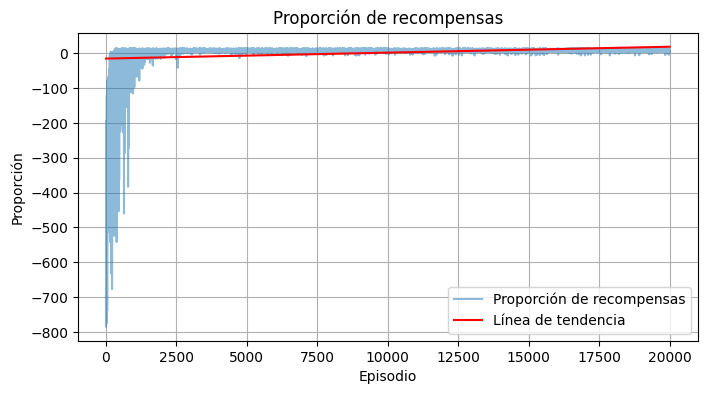

In [32]:
plot(rewards_per_episode_sarsa)  # Pass only rewards_per_episode

Por otra parte, la longitud de los episodios desciende de forma marcada: en un principio, el agente requiere más de 200 pasos para completar la tarea, pero rápidamente reduce ese número hasta estabilizarse en torno a 20 o 25 pasos. Esta mejora refleja que el agente, a medida que explora y refina su comportamiento, identifica acciones más eficientes y, en consecuencia, completa cada episodio con un menor número de movimientos y penalizaciones.

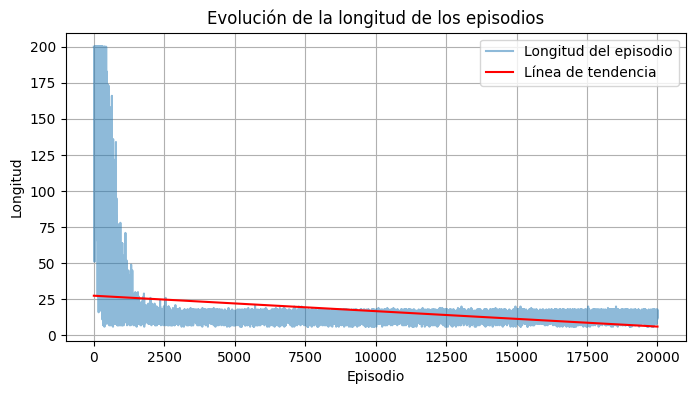

In [33]:
plot_episode_lengths(episodes_sizes_sarsa)

Extraemos la politica optima para despues poder mostrar un video con el camino solucion optimo encontrado por el agente.

In [34]:
# Primero, evaluamos la política óptima usando la Q del agente
optimal_policy, action_log, frames_recorded = optimal_policy_from_q(env_sarsa, agent.Q)

# Mostramos los resultados
print("Política óptima obtenida:\n", optimal_policy)
print("\nAcciones tomadas:\n", action_log)
print("\nGrid del entorno:\n", env_sarsa.render())

Política óptima obtenida:
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

Acciones tomadas:
 0, 3, 3, 0, 0, 4, 1, 1, 2, 2, 2, 0, 0, 5, 

Grid del entorno:
 [[[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[114 116 115]
  [114 116 115]
  [126 127 126]
  ...
  [112 113 111]
  [112 113 111]
  [118 117 115]]

 ...

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[115 112 112]
  [115 112 112]
  [119 119 117]
  ...
  [123 119 118]
  [123 119 118]
  [114 114 117]]]


In [35]:
# Definimos la función de política GREEDY a partir de la Q del agente
def greedy_policy(state):
    import numpy as np
    return np.argmax(agent.Q[state])

Mostramos el video

In [36]:
video_dir = record_policy_with_fn(greedy_policy, env=env_sarsa, video_dir="videos_sarsa")
latest_video_file = get_latest_episode_video_file(video_dir)
print("Video grabado:", latest_video_file)
embed_video(latest_video_file)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos_sarsa folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video grabado: videos_sarsa/rl-video-episode-20000.mp4


Iniciamos QLearning y lo entranamos

In [37]:
env_qlearning = gym.make("Taxi-v3", render_mode="rgb_array")
env_qlearning = gym.wrappers.RecordVideo(env_qlearning, video_folder="videos_qlearning")

agent = QLearningAgent(
    env=env_qlearning,
    gamma=GAMMA,
    alpha=0.1,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode_ql = []
episodes_sizes_ql = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env_qlearning.reset()
    done = False
    episode_reward = 0
    episode_steps = 0

    while not done:
        action = agent.get_action(obs)  # Se elige la acción aquí en cada paso
        next_obs, reward, terminated, truncated, info = env_qlearning.step(action)
        done = terminated or truncated

        agent.update(obs, action, reward, next_obs, done)

        # Actualizar estado y métricas
        obs = next_obs
        episode_reward += reward
        episode_steps += 1

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode_ql.append(episode_reward)
    episodes_sizes_ql.append(episode_steps)

    # Para mostrar la evolución
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

 10%|▉         | 1956/20000 [00:24<00:15, 1150.84it/s]

Éxito promedio: -46.885, Épsilon: 0.002


 20%|██        | 4095/20000 [00:27<00:25, 611.76it/s]

Éxito promedio: -19.52775, Épsilon: 0.002


 30%|███       | 6023/20000 [00:28<00:12, 1113.71it/s]

Éxito promedio: -10.354166666666666, Épsilon: 0.002


 40%|███▉      | 7957/20000 [00:29<00:07, 1569.24it/s]

Éxito promedio: -5.795, Épsilon: 0.002


 50%|█████     | 10081/20000 [00:32<00:11, 831.52it/s]

Éxito promedio: -3.0803, Épsilon: 0.002


 62%|██████▏   | 12313/20000 [00:33<00:06, 1280.64it/s]

Éxito promedio: -1.2685833333333334, Épsilon: 0.002


 70%|███████   | 14030/20000 [00:35<00:05, 1100.79it/s]

Éxito promedio: 0.030285714285714287, Épsilon: 0.002


 80%|████████  | 16028/20000 [00:36<00:03, 1033.93it/s]

Éxito promedio: 1.0058125, Épsilon: 0.002


 91%|█████████ | 18228/20000 [00:37<00:01, 1212.10it/s]

Éxito promedio: 1.7635555555555555, Épsilon: 0.002


100%|██████████| 20000/20000 [00:39<00:00, 511.94it/s] 


En esta gráfica, se observa cómo el agente **Q-Learning**, reduce con rapidez la penalización inicial y va incrementando su éxito promedio a medida que aprende. Los valores de recompensa negativa (cercanos a -46) en los primeros episodios se corrigen con relativa velocidad hasta llegar a valores positivos (alrededor de 1.8). Esto indica que el agente encuentra una política cada vez más cercana a la óptima, minimizando las penalizaciones por movimientos ineficientes o acciones incorrectas.

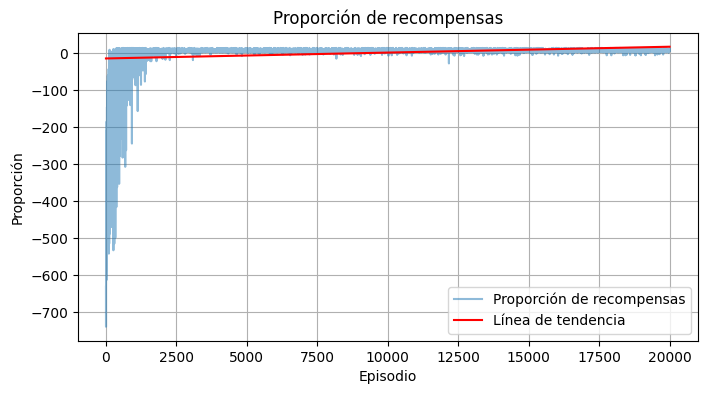

In [38]:
plot(rewards_per_episode_ql)  # Pass only rewards_per_episode


La segunda gráfica, que representa la **longitud de los episodios**, pone de manifiesto una drástica disminución de los pasos necesarios para completar cada episodio. Tras comenzar con más de 200 pasos, el agente estabiliza su rendimiento en torno a 20-25 movimientos. Esto revela que Q-Learning, al estimar el valor máximo futuro $(\max_{a'} Q(s', a'))$ en cada actualización, converge rápidamente hacia secuencias de acciones más eficientes y efectivas para recoger y dejar al pasajero con el menor número de penalizaciones.

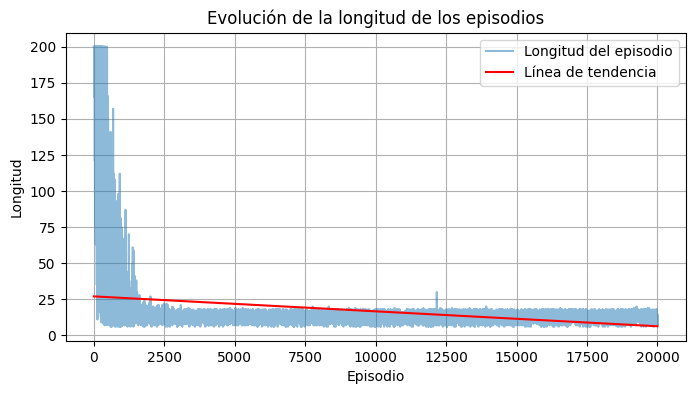

In [39]:
plot_episode_lengths(episodes_sizes_ql)

Extraemos la politica optima para despues poder mostrar un video con el camino solucion optimo encontrado por el agente.

In [40]:
# Primero, evaluamos la política óptima usando la Q del agente
optimal_policy, action_log, frames_recorded = optimal_policy_from_q(env_qlearning, agent.Q)

# Mostramos los resultados
print("Política óptima obtenida:\n", optimal_policy)
print("\nAcciones tomadas:\n", action_log)
print("\nGrid del entorno:\n", env_qlearning.render())

Política óptima obtenida:
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

Acciones tomadas:
 3, 3, 1, 3, 1, 4, 0, 0, 0, 0, 5, 

Grid del entorno:
 [[[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[114 116 115]
  [114 116 115]
  [126 127 126]
  ...
  [112 113 111]
  [112 113 111]
  [118 117 115]]

 ...

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[115 112 112]
  [115 112 112]
  [119 119 117]
  ...
  [123 119 118]
  [123 119 118]
  [114 114 117]]]


Mostramos el video

In [41]:
video_dir = record_policy_with_fn(greedy_policy, env=env_qlearning, video_dir="videos_qlearning")
latest_video_file = get_latest_episode_video_file(video_dir)
print("Video grabado:", latest_video_file)
embed_video(latest_video_file)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos_qlearning folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video grabado: videos_qlearning/rl-video-episode-20000.mp4


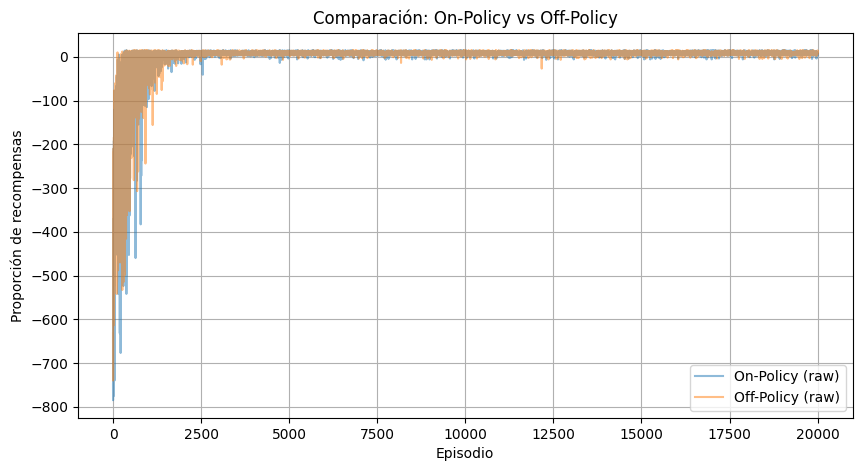

In [42]:
plot_comparison(rewards_per_episode_sarsa, rewards_per_episode_ql, True)

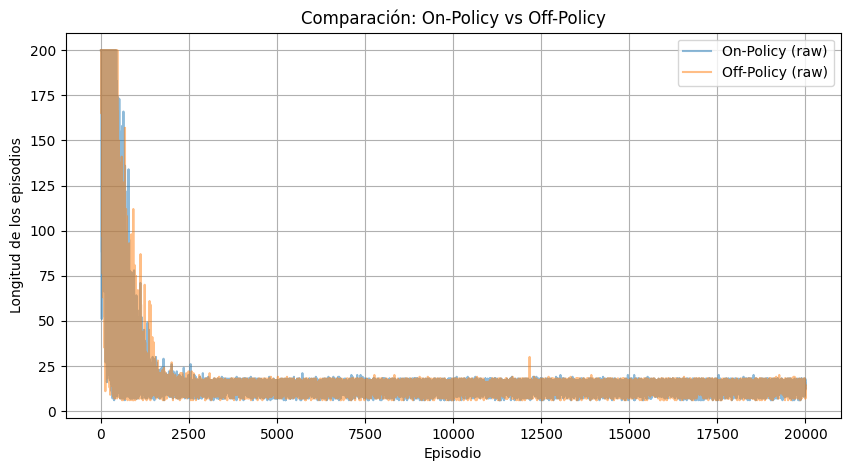

In [43]:
plot_comparison(episodes_sizes_sarsa, episodes_sizes_ql, False)

En la comparación de **SARSA** (azul) frente a **Q-Learning** (naranja), se observa que ambas curvas convergen hacia recompensas cercanas a 0 o incluso positivas, indicando que ambos métodos logran encontrar políticas efectivas para resolver la tarea. Sin embargo, Q-Learning muestra un aprendizaje ligeramente más rápido en las primeras etapas, reflejando su naturaleza *off-policy*, que le permite actualizar sus valores estimados considerando la acción óptima en el siguiente estado, independientemente de la acción realmente elegida. SARSA, al ser *on-policy*, puede mostrar una progresión más estable, pero a un ritmo ligeramente menor. Aun así, al final del entrenamiento, las diferencias en rendimiento se vuelven mínimas, con ambos agentes logrando episodios cortos y recompensas cercanas al óptimo.

En términos de velocidad de convergencia, tanto Monte Carlo Off-Policy como Q-Learning suelen mostrar un aprendizaje más rápido que sus contrapartes on-policy. Esto se debe a que en Off-Policy (ya sea MC Off-Policy o Q-Learning), la actualización de los valores puede basarse en estimaciones óptimas (o en otra política distinta) incluso cuando la recolección de datos no sea completamente óptima. Por el contrario, Monte Carlo On-Policy y SARSA (ambos on-policy) tienden a ser más conservadores, pues ajustan la política con base en la misma estrategia de exploración que están utilizando para actuar, lo cual puede ralentizar ligeramente la convergencia inicial.

Tambien hemos observado que las **diferencias temporales (TD)** suelen converger antes que los métodos de **Monte Carlo** principalmente porque no necesitan esperar al final de cada episodio para realizar las actualizaciones de los valores. En Monte Carlo, la estimación de la recompensa acumulada (retorno) depende de haber completado todo el episodio, lo que puede prolongar el tiempo hasta que el agente aproveche la experiencia obtenida. En cambio, los métodos TD (como SARSA y Q-Learning) hacen uso de la recompensa inmediata y del valor estimado del siguiente estado para ajustar $Q(s,a)$ en cada paso, recibiendo retroalimentación más rápida y reduciendo la varianza de las actualizaciones.

Además, el proceso de **bootstrapping** (apoyarse en valores ya calculados para actualizar la estimación actual) permite que los métodos TD se adapten dinámicamente a nuevas situaciones sin requerir episodios completos, acelerando el aprendizaje. Este enfoque progresivo de actualización les brinda la ventaja de empezar a mejorar las estimaciones de valor mucho antes de que un episodio concluya, motivo por el cual suelen converger en menos tiempo que los métodos basados estrictamente en el retorno final de cada episodio.  

# **Control Con Aproximaciones**

## SARSA Semi-Gradiente

SARSA Semi-Gradiente es una extensión del algoritmo SARSA que integra la aproximación de funciones para estimar la función de acción-valor \(Q(s,a)\) mediante un modelo parametrizado, como puede ser un modelo lineal o una red neuronal. En este enfoque, la actualización de los parámetros se realiza utilizando el gradiente de la función aproximada respecto a los parámetros, pero de forma "semi-gradiente", ya que se considera fijo el valor objetivo obtenido a partir de la política en el siguiente estado. Esto permite aplicar actualizaciones incrementales basadas en la diferencia temporal (TD error) sin propagar el gradiente a través del término objetivo, facilitando la estabilidad y eficiencia del aprendizaje en espacios de estados de alta dimensión o continuos.

Definimos la clase SARSA Semi Gradiente

In [44]:
class SARSASemiGradient:
    def __init__(self, env, alpha=0.01, gamma=0.99, epsilon=1.0, epsilon_decay=0.9999, min_epsilon=0.01):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Inicializar pesos w con valores pequeños
        self.w = np.random.rand(env.observation_space.n, env.action_space.n) * 0.01

    def featurize_state_action(self, state, action):
        """Codificación simple de estado-acción como one-hot vector"""
        features = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        features[state, action] = 1
        return features

    def q_value(self, state, action):
        """Calcula Q(s,a) como w^T * x(s,a)"""
        features = self.featurize_state_action(state, action)
        return np.sum(self.w * features)

    def get_action(self, state):
        """Política epsilon-greedy"""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración
        else:
            return np.argmax([self.q_value(state, a) for a in range(self.env.action_space.n)])  # Explotación

    def update(self, state, action, reward, next_state, next_action, done):
        """Actualización de pesos w con semi-gradiente"""
        features = self.featurize_state_action(state, action)
        target = reward + (0 if done else self.gamma * self.q_value(next_state, next_action))
        error = target - self.q_value(state, action)
        self.w += self.alpha * error * features  # Gradiente ascendente

        # Reducir epsilon
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

Iniciamos el agente y entrenamos

In [45]:
# Crear entorno con grabación de video
env_sarsa_sg = gym.make("Taxi-v3", render_mode="rgb_array")
env_sarsa_sg = gym.wrappers.RecordVideo(env_sarsa_sg, video_folder="videos_sarsa_sg")

# Inicializar el agente SARSA Semi-Gradiente
agent = SARSASemiGradient(
    env=env_sarsa_sg,
    alpha=0.01,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode_sarsa_sg = []
episodes_sizes_sarsa_sg = []

# Para mostrar la evolución en consola
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env_sarsa_sg.reset(seed=seed)
    action = agent.get_action(obs)
    done = False
    episode_reward = 0
    episode_steps = 0

    while not done:
        next_obs, reward, terminated, truncated, info = env_sarsa_sg.step(action)
        done = terminated or truncated
        next_action = agent.get_action(next_obs) if not done else None

        agent.update(obs, action, reward, next_obs, next_action, done)

        # Actualizar estado y métricas
        obs, action = next_obs, next_action
        episode_reward += reward
        episode_steps += 1

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode_sarsa_sg.append(episode_reward)
    episodes_sizes_sarsa_sg.append(episode_steps)

    # Mostrar información de progreso
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

print("Entrenamiento de SARSA Semi-Gradiente completado.")

 10%|█         | 2055/20000 [00:29<00:43, 409.16it/s]

Éxito promedio: -26.7745, Épsilon: 0.002


 20%|██        | 4040/20000 [00:33<00:42, 379.18it/s]

Éxito promedio: -8.92575, Épsilon: 0.002


 30%|███       | 6008/20000 [00:36<00:37, 373.33it/s]

Éxito promedio: -2.978833333333333, Épsilon: 0.002


 40%|████      | 8004/20000 [00:41<00:31, 380.51it/s]

Éxito promedio: -0.01375, Épsilon: 0.002


 50%|█████     | 10008/20000 [00:44<00:26, 383.74it/s]

Éxito promedio: 1.77, Épsilon: 0.002


 60%|██████    | 12035/20000 [00:48<00:20, 381.32it/s]

Éxito promedio: 2.962666666666667, Épsilon: 0.002


 70%|███████   | 14057/20000 [00:53<00:16, 365.98it/s]

Éxito promedio: 3.8135, Épsilon: 0.002


 80%|███████▉  | 15992/20000 [00:56<00:06, 643.44it/s]

Éxito promedio: 4.4484375, Épsilon: 0.002


 90%|█████████ | 18002/20000 [01:00<00:05, 354.43it/s]

Éxito promedio: 4.945166666666666, Épsilon: 0.002


100%|██████████| 20000/20000 [01:04<00:00, 308.31it/s]

Entrenamiento de SARSA Semi-Gradiente completado.


En la grafica de *Proporción de recompensas* se aprecia un patrón de aprendizaje progresivo: al inicio, las recompensas son bastante negativas (cerca de -27 en el 10% del entrenamiento), pero se vuelven menos negativas conforme avanza, hasta conseguir un exito de casi el 5. Esta mejora refleja cómo el agente, utilizando aproximación de funciones (en lugar de una tabla Q discreta), aprende a reducir los errores y penalizaciones a medida que explora el entorno. La línea de tendencia en la primera gráfica confirma esta evolución positiva en la recompensa promedio.

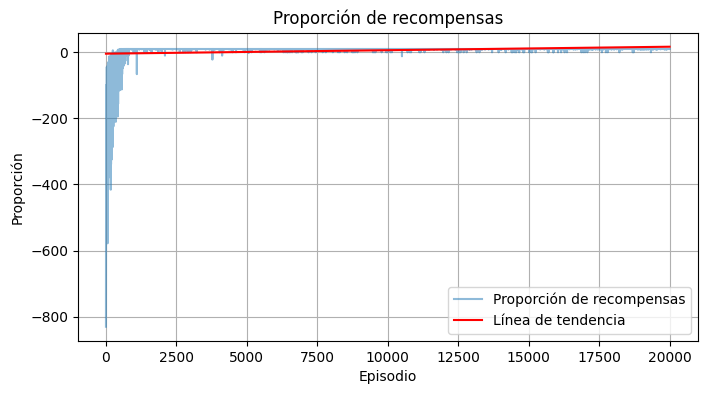

In [46]:
plot(rewards_per_episode_sarsa_sg)  # Pass only rewards_per_episode

En la grafica de *Evolución de los episodios* se ve claramente que la longitud de los episodios desciende rapidamente, pasando de más de 200 pasos a alrededor de 15. Esto indica que el agente cada vez necesita menos movimientos para completar la tarea. La aproximación por semi-gradiente permite al algoritmo generalizar mejor en el espacio de estados, especialmente si es muy grande o continuo, aunque a veces conlleva un proceso de convergencia más pausado en comparación con métodos tabulares.

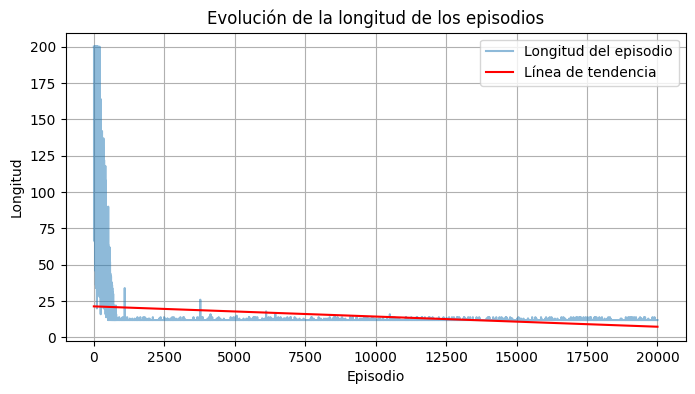

In [47]:
plot_episode_lengths(episodes_sizes_sarsa_sg)

Funcion para evaluar la politica óptima

In [48]:
def optimal_policy_from_q(env, agent):
    """Evalúa la política óptima aprendida a partir de los valores de Q estimados por SARSA SG."""
    optimal_policy = np.zeros(env.observation_space.n, dtype=int)
    action_log = []
    frames = []

    for state in range(env.observation_space.n):
        optimal_policy[state] = np.argmax([agent.q_value(state, a) for a in range(env.action_space.n)])

    # Simulación de la política óptima
    state, _ = env.reset(seed=seed)
    done = False

    while not done:
        frames.append(env.render())  # Guardar la imagen del entorno
        action = optimal_policy[state]
        action_log.append(action)
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    return optimal_policy, action_log, frames

In [49]:
# Primero, evaluamos la política óptima usando la Q del agente
optimal_policy, action_log, frames_recorded = optimal_policy_from_q(env_sarsa_sg, agent)

# Mostramos los resultados
print("Política óptima obtenida:\n", optimal_policy)
print("\nAcciones tomadas:\n", action_log)
print("\nGrid del entorno:\n", env_qlearning.render())

Política óptima obtenida:
 [3 0 4 0 2 0 3 4 0 1 1 3 4 1 1 3 5 2 4 2 1 2 1 2 5 2 3 4 4 3 1 5 1 1 0 5 2
 0 0 5 2 5 5 3 4 1 5 5 2 2 3 3 0 3 5 4 2 2 3 4 3 5 4 2 5 4 1 5 5 2 3 5 0 0
 3 5 5 2 1 0 5 2 5 2 2 1 2 5 4 0 0 4 4 1 5 0 2 5 3 1 1 4 3 2 2 0 4 1 1 1 5
 0 1 1 1 5 3 0 4 2 4 4 2 0 4 0 4 5 5 2 3 3 5 0 1 3 2 0 5 0 3 4 5 0 1 1 1 0
 5 2 3 4 1 0 4 2 1 1 3 0 4 2 1 0 0 2 0 3 5 1 5 0 0 0 0 5 5 2 2 5 3 4 4 4 5
 5 5 1 2 1 5 4 4 1 0 3 4 1 0 1 0 3 5 0 3 2 4 2 3 1 3 4 5 2 4 1 1 2 0 3 4 4
 4 4 2 4 1 1 5 3 1 2 3 2 3 1 0 2 3 1 3 4 5 3 5 4 3 4 3 1 0 2 4 2 2 2 4 2 4
 1 2 3 0 3 4 4 1 5 0 2 5 1 4 0 0 5 2 2 4 5 3 3 0 4 4 0 4 5 5 4 3 3 3 3 2 2
 1 1 3 3 1 0 5 1 1 2 5 5 2 0 0 1 0 0 5 0 5 1 5 4 4 0 0 5 4 0 4 3 3 0 3 0 3
 1 4 1 2 0 5 2 5 5 2 2 2 1 5 4 1 4 1 2 2 1 2 1 4 0 0 2 4 1 3 3 2 4 4 0 5 3
 2 0 4 0 0 0 0 2 5 2 3 2 1 2 4 3 1 2 1 5 5 2 4 3 5 5 5 1 3 2 2 4 2 5 4 2 3
 2 1 4 5 3 1 0 5 2 3 0 3 0 4 0 0 2 1 4 1 1 3 3 1 4 1 1 5 4 1 1 2 4 2 0 4 1
 2 1 3 1 2 2 4 4 0 1 5 4 5 3 3 4 3 0 4 3 1 3 4 5 0 1 1 2 0 4 1 5 5 1 1 5 

In [50]:
def greedy_policy_sarsa_sg(state, agent):
    """Selecciona la acción óptima para SARSA Semi-Gradiente usando la función aproximadora."""
    return np.argmax([agent.q_value(state, a) for a in range(agent.env.action_space.n)])

In [51]:
def record_policy_with_fn_SarsaDQL(policy_fn, agent, env, num_episodes=1, video_dir="videos"):
    """Graba un video ejecutando una política greedy sin exploración."""
    os.makedirs(video_dir, exist_ok=True)

    env = gym.wrappers.RecordVideo(env, video_folder=video_dir, episode_trigger=lambda ep: ep == 0)

    state, _ = env.reset(seed=seed)
    done = False

    while not done:
        action = policy_fn(state, agent)  # Aplicar la política óptima aprendida
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()

    return video_dir


Mostramos el video

In [52]:
# Grabar el video con la mejor política aprendida
video_dir = record_policy_with_fn_SarsaDQL(greedy_policy_sarsa_sg, agent, env_sarsa_sg, video_dir="videos_sarsa_sg")

# Obtener el último video grabado
latest_video_file = get_latest_episode_video_file(video_dir)

# Mostrar información del video grabado
print("Video grabado:", latest_video_file)

# Mostrar el video en el notebook
embed_video(latest_video_file)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos_sarsa_sg folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video grabado: videos_sarsa_sg/rl-video-episode-20000.mp4


## Deep Q-Learning

Deep Q-Learning (DQN) es una extensión de Q-Learning que emplea redes neuronales profundas para aproximar la función de acción-valor $Q(s, a)$ en lugar de usar una tabla. En este método, la red toma como entrada el estado del entorno y produce los valores $Q$ estimados para cada acción posible, permitiendo escalar el aprendizaje por refuerzo a espacios de estado de alta dimensión. Durante el entrenamiento, se utilizan técnicas como **experience replay** (para romper la correlación entre muestras) y **target networks** (para estabilizar la convergencia), reduciendo la varianza y mejorando la estabilidad de la actualización de parámetros.

Definimos la clase de Deep Q-Learning

In [53]:
import torch.optim as optim
import torch.nn as nn
import torch
import random

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # No activación final (Q-values)

In [54]:
class DQNAgent:
    def __init__(self, env, alpha=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.9995, min_epsilon=0.01, batch_size=32, target_update_freq=100):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq  # Cada cuántos pasos actualizamos la target_network

        # Red principal y Red Objetivo
        self.model = DQN(env.observation_space.n, env.action_space.n)
        self.target_network = DQN(env.observation_space.n, env.action_space.n)
        self.target_network.load_state_dict(self.model.state_dict())  # Inicializar con los mismos pesos

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.alpha)
        self.criterion = nn.MSELoss()

        self.replay_buffer = []  # Buffer de memoria para Experience Replay
        self.steps = 0  # Contador de pasos totales

    def get_action(self, state):
        """Estrategia epsilon-greedy para elegir acción."""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración

        # Convertir el estado a representación one-hot
        state_tensor = torch.tensor(np.eye(self.env.observation_space.n)[state], dtype=torch.float32).unsqueeze(0)

        with torch.no_grad():
            q_values = self.model(state_tensor)  # Obtener valores Q

        return torch.argmax(q_values, dim=1).item()  # Seleccionar la mejor acción

    def update(self, state, action, reward, next_state, done):
        """Guarda la experiencia y entrena con un minibatch."""
        self.replay_buffer.append((state, action, reward, next_state, done))

        if len(self.replay_buffer) < self.batch_size:  # Esperar hasta que haya suficientes datos
            return

        # Seleccionar un minibatch de experiencias
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # **Corrección: Indexar `np.eye()` correctamente**
        states = torch.tensor(np.eye(self.env.observation_space.n)[list(states)], dtype=torch.float32)
        next_states = torch.tensor(np.eye(self.env.observation_space.n)[list(next_states)], dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        # Calcular Q-target con la red objetivo
        with torch.no_grad():
            target_q_values = rewards + (1 - dones) * self.gamma * torch.max(self.target_network(next_states), dim=1)[0]

        # Calcular Q actual de la red principal
        q_values = self.model(states).gather(1, torch.tensor(actions, dtype=torch.long).unsqueeze(1)).squeeze()

        # Calcular pérdida y actualizar pesos
        loss = self.criterion(q_values, target_q_values.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Cada ciertos pasos actualizamos la red objetivo
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.model.state_dict())

Inicializamos Deep Q-Learning y entrenamos el agente

In [55]:
# Inicializar entorno con grabación de video cada 100 episodios
env_dqn = gym.make("Taxi-v3", render_mode="rgb_array")
env_dqn = gym.wrappers.RecordVideo(env_dqn, video_folder="videos_dqn", episode_trigger=lambda ep: ep % 100 == 0)

# Inicializar el agente DQN
agent = DQNAgent(
    env=env_dqn,
    alpha=0.001,  # Learning rate bajo para redes neuronales
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.9995,
    min_epsilon=0.01
)

# Definir variables de entrenamiento
NUM_EPISODES = 20000
rewards_per_episode_dqn = []
episodes_sizes_dqn = []

stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Entrenamiento del DQN
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env_dqn.reset(seed=seed)
    done = False
    episode_reward = 0
    episode_steps = 0

    while not done:
        action = agent.get_action(obs)  # Se elige la acción en cada paso
        next_obs, reward, terminated, truncated, info = env_dqn.step(action)
        done = terminated or truncated

        agent.update(obs, action, reward, next_obs, done)

        # Actualizar estado y métricas
        obs = next_obs
        episode_reward += reward
        episode_steps += 1

    # Guardar métricas del episodio
    stats += episode_reward
    list_stats.append(stats / (episode + 1))
    rewards_per_episode_dqn.append(episode_reward)
    episodes_sizes_dqn.append(episode_steps)

    # Reducir epsilon gradualmente
    agent.epsilon = max(agent.min_epsilon, agent.epsilon * agent.epsilon_decay)

    # Mostrar información de progreso
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

print("Entrenamiento de Deep Q-Learning completado.")


 10%|█         | 2001/20000 [06:01<29:25, 10.19it/s]

Éxito promedio: -168.9895, Épsilon: 0.36760355841993914


 20%|██        | 4001/20000 [07:57<26:32, 10.05it/s]

Éxito promedio: -87.2355, Épsilon: 0.1351999761510762


 30%|███       | 6003/20000 [09:32<14:59, 15.56it/s]

Éxito promedio: -56.6435, Épsilon: 0.04972485475880578


 40%|████      | 8003/20000 [11:03<12:48, 15.61it/s]

Éxito promedio: -40.583, Épsilon: 0.018288177640071544


 50%|█████     | 10001/20000 [12:31<08:09, 20.41it/s]

Éxito promedio: -30.7711, Épsilon: 0.01


 60%|██████    | 12002/20000 [14:01<08:34, 15.54it/s]

Éxito promedio: -24.222833333333334, Épsilon: 0.01


 70%|███████   | 14000/20000 [15:31<05:26, 18.36it/s]

Éxito promedio: -19.544, Épsilon: 0.01


 80%|████████  | 16003/20000 [17:11<04:52, 13.65it/s]

Éxito promedio: -16.0369375, Épsilon: 0.01


 90%|█████████ | 18003/20000 [18:43<02:03, 16.17it/s]

Éxito promedio: -13.301833333333333, Épsilon: 0.01


100%|██████████| 20000/20000 [20:18<00:00, 16.42it/s]

Entrenamiento de Deep Q-Learning completado.


En la grafica *Proporcion de recompensas* se ve cómo, a medida que avanzan los episodios, la proporción de recompensas pasa de valores muy negativos a valores cada vez menos negativos, acercándose progresivamente a 0. La línea de tendencia en rojo confirma esta mejora, mostrando una curva ascendente que indica que el agente va reduciendo las penalizaciones y obteniendo mayores recompensas netas. Esto se relaciona directamente con el hecho de que, conforme el entrenamiento progresa, el agente aprende mejores estrategias para completar la tarea de forma más eficiente y con menos errores.

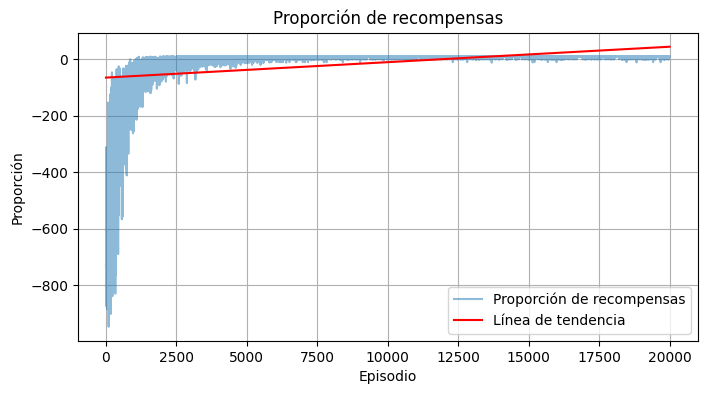

In [56]:
plot(rewards_per_episode_dqn)  # Pass only rewards_per_episode

En la grafica *Evolucion de la longitud de los episodios* se observa la disminución paulatina del número de pasos que el agente necesita para finalizar cada episodio. Al principio, la longitud de los episodios puede superar los 200 pasos, lo que evidencia la fase inicial de exploración y la falta de un plan eficaz. Sin embargo, a medida que el agente aprende la dinámica del entorno, los episodios se acortan significativamente, llegando a rondar las 20-30 acciones o incluso menos. La línea de tendencia en rojo refuerza esta lectura, mostrando claramente que el agente converge hacia trayectorias más rápidas y eficientes para alcanzar su objetivo.

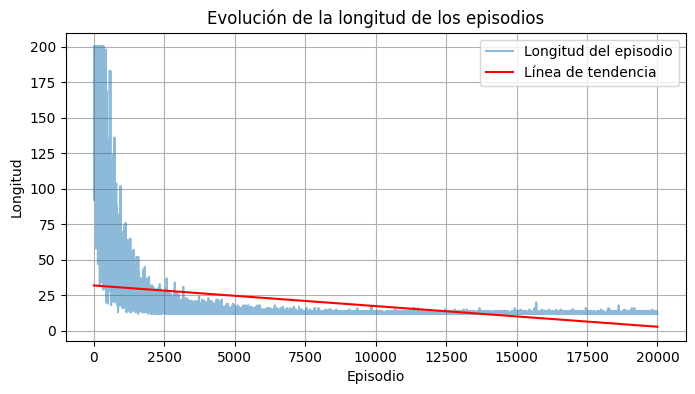

In [57]:
plot_episode_lengths(episodes_sizes_dqn)

Funcion para evaluar la política óptima aprendida a partir de los valores de Q estimados por la red neuronal en DQN

In [58]:
def optimal_policy_from_dqn(env, agent):
    optimal_policy = np.zeros(env.observation_space.n, dtype=int)
    action_log = []
    frames = []

    for state in range(env.observation_space.n):
        # Predecir Q(s,a) con la red neuronal y elegir la mejor acción
        state_tensor = torch.tensor(np.eye(env.observation_space.n)[state], dtype=torch.float32)
        optimal_policy[state] = torch.argmax(agent.model(state_tensor)).item()

    # Simulación de la política óptima
    state, _ = env.reset(seed=seed)
    done = False

    while not done:
        frames.append(env.render())  # Guardar la imagen del entorno
        action = optimal_policy[state]
        action_log.append(action)
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    return optimal_policy, action_log, frames


Evaluamos deep Q-Learning

In [59]:
# Evaluar la política óptima aprendida por Deep Q-Learning
optimal_policy_dqn, action_log_dqn, frames_dqn = optimal_policy_from_dqn(env_dqn, agent)

# Mostrar resultados
print("Política óptima obtenida en DQN:\n", optimal_policy_dqn)
print("\nAcciones tomadas:\n", action_log_dqn)
print("\nGrid del entorno:\n", env_dqn.render())  # Mostrar el entorno de DQN


Política óptima obtenida en DQN:
 [2 4 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 0 2 2 2 5 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 0 2 2 2 0 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 0 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 2 2 2 0 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 3
 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 1 3 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2
 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2
 2 1 2 2 2 0 2 2 2 2 2 2 2 0 2 2 2 1 2 2 2 1 2 2 2 0 2 2 2 2 2 2 2 0 2 2 2
 1 2 2 2 1 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 4 2 2 2 1 2 2 2 5 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 1 2 2 2 2 2
 2 2 2 2 2 1 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2

In [60]:
def greedy_policy_dqn(state, agent):
    """Selecciona la acción óptima para DQN usando la red neuronal."""
    state_tensor = torch.tensor(np.eye(agent.env.observation_space.n)[state], dtype=torch.float32)
    return torch.argmax(agent.model(state_tensor)).item()

Mostramos video de la solucion de Deep Q-Learning

In [61]:
# Grabar el video con la mejor política aprendida
video_dir = record_policy_with_fn_SarsaDQL(greedy_policy_dqn, agent, env_dqn, video_dir="videos_dqn")

# Obtener el último video grabado
latest_video_file = get_latest_episode_video_file(video_dir)

# Mostrar información del video grabado
print("Video grabado:", latest_video_file)

# Mostrar el video en el notebook
embed_video(latest_video_file)


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos_dqn folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video grabado: videos_dqn/rl-video-episode-20000.mp4


En esta grafica se observa cómo Deep Q-Learning (curva naranja) comienza con valores muy negativos y muestra una mayor dispersión en los primeros episodios, mientras que Sarsa semigradiente (curva azul) tiene una variabilidad algo menor en ese mismo rango inicial. Sin embargo, ambas convergen hacia valores cercanos a 0, lo que indica que tanto  Deep Q-Learning como Sarsa semigradiente logran reducir las penalizaciones y mejorar sus recompensas con el paso de los episodios. La principal diferencia radica en la rapidez y la forma de la convergencia: Deep Q-Learning parece tener un arranque más volátil pero alcanza recompensas cercanas a 0 de forma relativamente rápida, mientras que Sarsa semigradiente se muestra más estable en su camino hacia la convergencia.

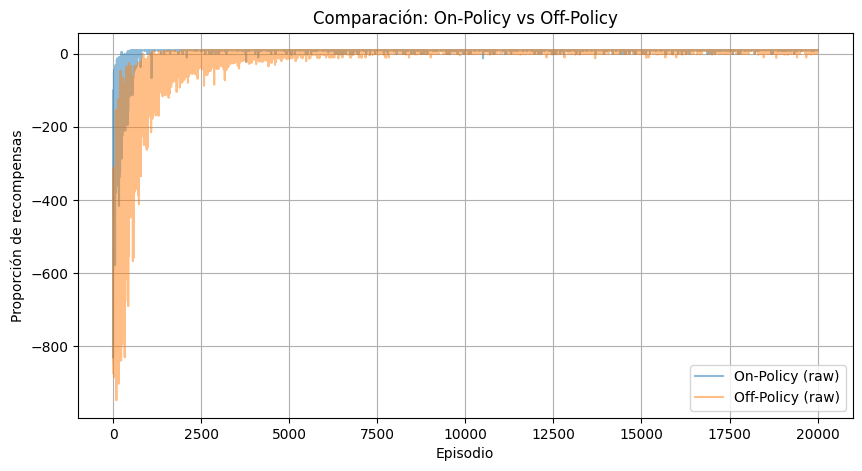

In [62]:
plot_comparison(rewards_per_episode_sarsa_sg, rewards_per_episode_dqn, True)

En la segunda gráfica, que representa la longitud de los episodios, también se aprecia un patrón de convergencia en ambos métodos. La estrategia Deep Q-Learning (naranja) arranca con episodios muy extensos y dispersos, pero los reduce drásticamente a medida que aprende la dinámica del entorno. Por su parte, Sarsa semigradiente (azul) mantiene una trayectoria más “controlada” en términos de pasos, mostrando menos picos extremos. Aun así, ambas estrategias finalizan con un número de pasos significativamente menor que al inicio, lo que evidencia que los dos algoritmos logran encontrar rutas más eficientes para completar la tarea.

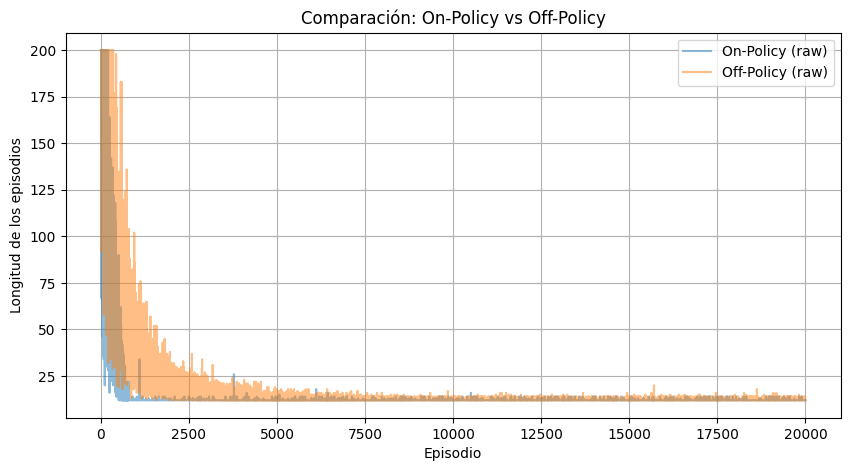

In [63]:
plot_comparison(episodes_sizes_sarsa_sg, episodes_sizes_dqn, False)

Como conclusion mencionar que los algoritmos basados en actualizaciones off-policy (Q-Learning y Monte Carlo Off) destacan por alcanzar de forma más rápida una reducción significativa en la longitud de los episodios, lo que indica una convergencia acelerada hacia una política eficiente. En cambio, los métodos on-policy (Monte Carlo On y SARSA) muestran una mejora más paulatina, siendo el enfoque SARSA semigradiente una alternativa intermedia que, gracias a la aproximación funcional, logra mejoras tempranas en la eficiencia, aunque con una convergencia ligeramente menos contundente que la observada en los métodos off-policy. Por otro lado Deep Q-Learning alcanza unos resultados muy prometedores, pero al tratarse de una red neuronal el proceso de entrenamiento es mucho mas lento y en según qué situacion puede ser innecesario, pues modelos menos complejos pueden resolver el problema de manera satisfactoria.

Estas comparaciones resalta que, en el entorno estudiado, optar por técnicas off-policy puede ser ventajoso si el objetivo es alcanzar rápidamente episodios más cortos y, por ende, una política operativa más eficiente.